> # Mestrado Engenharia Informática
>
> ## **Algoritmos para Big Data**

> ### **Felipe Silva** # 121851

> ### **Fernando Piedade** # 109266

> **_*2023/24*_**


# Initial settings


## Additional packages and imports


In [1]:
import findspark, pyspark

from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

In [2]:
import os
import shutil

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [3]:
import nltk

nltk.download("wordnet")

from nltk.stem import WordNetLemmatizer

# Lemmatization reduces the words to their root or base forms, known as lemma.
#It was performed by WordNetLemmatizer() from the nltk.stem module.
# The lemmatizer called the lemmatize() function on each token present in the text and then combined the results.


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/felipesilva/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
from pyspark.ml import Pipeline, Transformer, PipelineModel
from pyspark.ml.feature import RegexTokenizer # tokenizer
from pyspark.ml.feature import HashingTF, IDF # vectorizer
from pyspark.ml.feature import StopWordsRemover # to remove stop words
from pyspark.ml.classification import LogisticRegression, LinearSVC, OneVsRest, NaiveBayes # ml models
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from pyspark.ml.param.shared import HasInputCol, HasOutputCol
from pyspark.ml.evaluation import MulticlassClassificationEvaluator # to evaluate the model
from pyspark.mllib.evaluation import MulticlassMetrics # # performance metrics

In [5]:
# Create the Spark session

findspark.init()
findspark.find()

spark = SparkSession\
        .builder\
        .appName("ADBFinacialReportsSecModelEvaluation")\
        .config("spark.sql.shuffle.partitions",200)\
        .config("spark.driver.memory", "12G")\
        .config("spark.executor.memory", "12G")\
        .config("spark.executor.cores", "4")\
        .config("spark.driver.maxResultSize", "4G")\
        .config("spark.sql.repl.eagereval.enabled",True)\
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer")\
        .config("spark.kryoserializer.buffer.max", "512m")\
        .config("spark.default.parallelism", 200)\
        .getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/03 01:12:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [7]:
data_dir = "../Datasets/financial-reports-sec/parquet/large/"
pipelines_path = "pipelines/"
pipelines_model_path = "pipelines_model/"

## Useful functions


In [8]:
def get_confusion_matrix_data(predictions):
  # important: need to cast to float type, and order by prediction, else it won't work
  preds_and_labels = predictions.select(['prediction','label']) \
    .withColumn('label', F.col('label') \
    .cast(FloatType())) \
    .orderBy('prediction')
  
  # generate metrics
  metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
  metrics_arr = metrics.confusionMatrix().toArray()

  return metrics_arr / np.sum(metrics_arr)

def plot_cofusion_matrix(data, title):
  
  # figure object
  fig, ax = plt.subplots(1, 1, figsize=(7, 7))

  # plot confusion matrix
  sns.heatmap(data, cmap='Blues', annot=True, fmt='.2%', ax=ax, square=True)
  
  fig.suptitle(title, fontsize=16)
  ax.set(xlabel="Predicted Label", ylabel="True Label")
  
  plt.tight_layout()
  plt.show()

def evaluation_metrics(predictions):
  # List of metrics to evaluate
  metrics = ["accuracy", "weightedPrecision", "weightedRecall", "f1"]

  # Initialize evaluator
  evaluator = MulticlassClassificationEvaluator()
  results = {}

  # Evaluate and collect each metric
  for metric in metrics:
    evaluator.setMetricName(metric)
    score = evaluator.evaluate(predictions)
    results[metric] = score

  return results

In [9]:
class Lemmatizer(Transformer, HasInputCol, HasOutputCol, DefaultParamsReadable, DefaultParamsWritable):
  def __init__(self, inputCol=None, outputCol=None):
    super(Lemmatizer, self).__init__()
    self.lemmatizer = WordNetLemmatizer()
    self._setDefault(inputCol=inputCol, outputCol=outputCol)
    self._set(inputCol=inputCol, outputCol=outputCol)
  
  def _transform(self, df):
    lemmatize_udf = F.udf(lambda words: [self.lemmatizer.lemmatize(word) for word in words], ArrayType(StringType()))
    return df.withColumn(self.getOutputCol(), lemmatize_udf(df[self.getInputCol()]))

In [10]:
df_test = spark.read.parquet(data_dir + "test.parquet")
df_train = spark.read.parquet(data_dir + "train.parquet")

## Load Pipeline and Analysis


In [11]:
pipeline = PipelineModel.load(f"{pipelines_model_path}LogisticRegression")
predictions = pipeline.transform(df_test)
metrics = evaluation_metrics(predictions)
cm_data = get_confusion_matrix_data(predictions)

24/06/03 00:36:20 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/06/03 00:37:05 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/06/03 00:37:45 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/06/03 00:38:23 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/06/03 00:39:02 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/06/03 00:39:42 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/06/03 00:40:04 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/06/03 00:40:43 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/06/03 00:40:43 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


## Generate Confusing Matrix


### check the better performance


accuracy, precision, recall, and F1 metrics


LogisticRegression Metrics:

Accuracy: 0.25500878734622145
Weightedprecision: 0.2115201919815865
Weightedrecall: 0.25500878734622145
F1: 0.2263569772010318


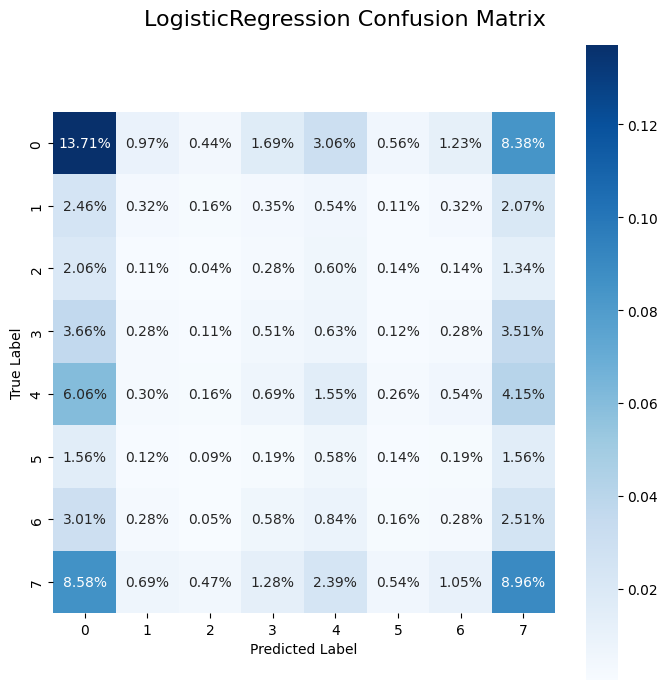

In [12]:
print("LogisticRegression Metrics:\n")
for metric, score in metrics.items():
  print(f"{metric.capitalize()}: {score}")

plot_cofusion_matrix(cm_data, "LogisticRegression Confusion Matrix")

In [11]:
pipeline = PipelineModel.load(f"{pipelines_model_path}LogisticRegression_Lemmatized")
predictions = pipeline.transform(df_test)
metrics = evaluation_metrics(predictions)
cm_data = get_confusion_matrix_data(predictions)

24/06/03 00:41:51 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/06/03 00:43:57 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/06/03 00:45:57 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/06/03 00:47:56 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/06/03 00:49:57 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/06/03 00:51:58 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/06/03 00:53:44 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/06/03 00:55:44 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/06/03 00:55:44 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB


LogisticRegression Lemmatized Metrics:

Accuracy: 0.24868189806678384
Weightedprecision: 0.2099578004007629
Weightedrecall: 0.2486818980667838
F1: 0.22379590044961586


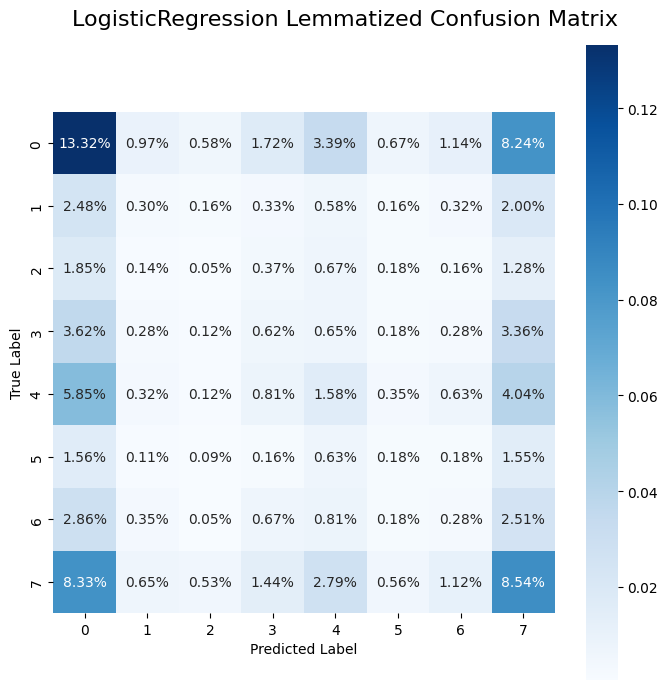

In [12]:
print("LogisticRegression Lemmatized Metrics:\n")
for metric, score in metrics.items():
  print(f"{metric.capitalize()}: {score}")

plot_cofusion_matrix(cm_data, "LogisticRegression Lemmatized Confusion Matrix")

In [11]:
pipeline = PipelineModel.load(f"{pipelines_model_path}LinearSVC")
predictions = pipeline.transform(df_test)
metrics = evaluation_metrics(predictions)
cm_data = get_confusion_matrix_data(predictions)

24/06/03 00:56:34 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/06/03 00:57:21 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/06/03 00:58:02 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/06/03 00:58:41 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/06/03 00:59:20 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/06/03 00:59:58 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/06/03 01:00:22 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/06/03 01:01:01 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/06/03 01:01:01 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB


LinearSVC Metrics:

Accuracy: 0.22864674868189808
Weightedprecision: 0.2134727803968196
Weightedrecall: 0.22864674868189805
F1: 0.22012097724783936


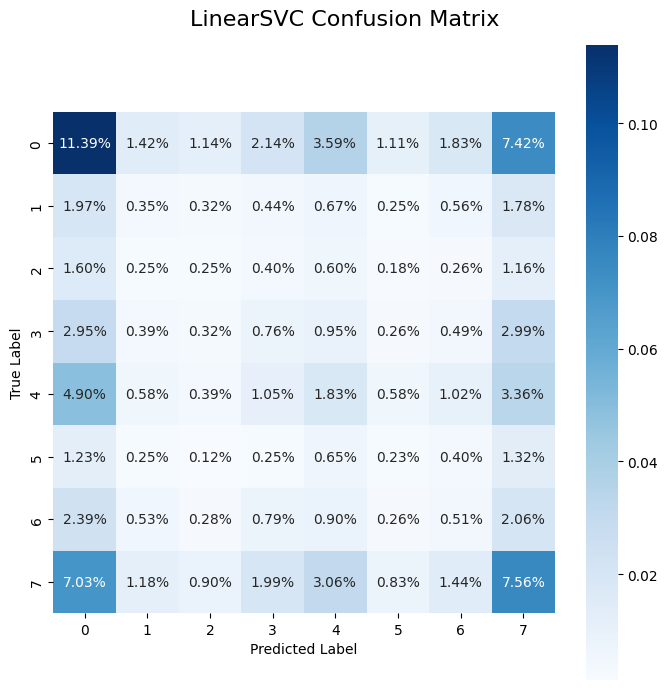

In [12]:
print("LinearSVC Metrics:\n")
for metric, score in metrics.items():
  print(f"{metric.capitalize()}: {score}")

plot_cofusion_matrix(cm_data, "LinearSVC Confusion Matrix")

In [11]:
pipeline = PipelineModel.load(f"{pipelines_model_path}LinearSVC_Lemmatized")
predictions = pipeline.transform(df_test)
metrics = evaluation_metrics(predictions)
cm_data = get_confusion_matrix_data(predictions)

24/06/03 01:12:38 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/06/03 01:15:12 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/06/03 01:17:41 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/06/03 01:20:14 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


In [ ]:
print("LinearSVC Lemmatized Metrics:\n")
for metric, score in metrics.items():
  print(f"{metric.capitalize()}: {score}")

plot_cofusion_matrix(cm_data, "LinearSVC Lemmatized Confusion Matrix")

In [11]:
pipeline = PipelineModel.load(f"{pipelines_model_path}NaiveBayes")
predictions = pipeline.transform(df_test)
metrics = evaluation_metrics(predictions)
cm_data = get_confusion_matrix_data(predictions)

24/06/03 01:01:48 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
24/06/03 01:02:34 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
24/06/03 01:03:13 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
24/06/03 01:03:52 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
24/06/03 01:04:32 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
24/06/03 01:05:11 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
24/06/03 01:05:35 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
24/06/03 01:06:14 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
24/06/03 01:06:14 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


NaiveBayes Metrics:

Accuracy: 0.19015817223198594
Weightedprecision: 0.2249971350923499
Weightedrecall: 0.19015817223198594
F1: 0.20300675926488243


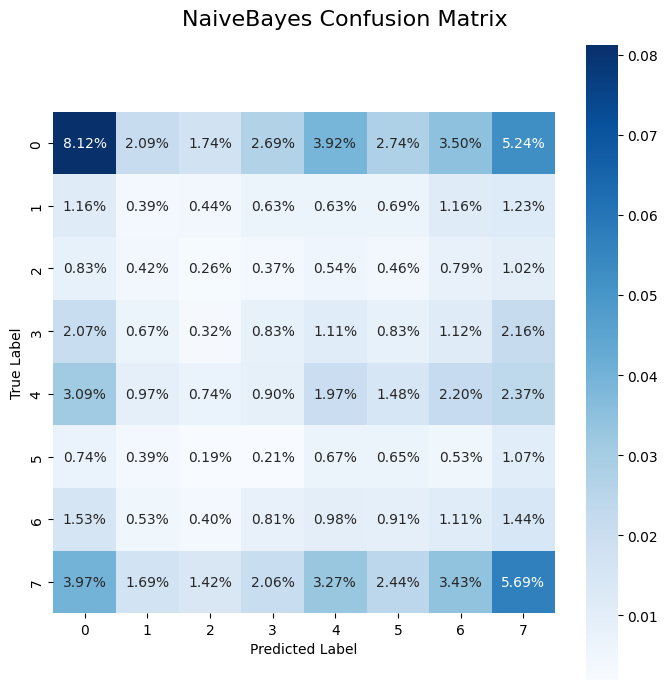

In [12]:
print("NaiveBayes Metrics:\n")
for metric, score in metrics.items():
  print(f"{metric.capitalize()}: {score}")

plot_cofusion_matrix(cm_data, "NaiveBayes Confusion Matrix")

In [11]:
pipeline_lsvc = PipelineModel.load(f"{pipelines_model_path}NaiveBayes_Lemmatized")
predictions = pipeline_lsvc.transform(df_test)
metrics = evaluation_metrics(predictions)
cm_data = get_confusion_matrix_data(predictions)

24/06/02 22:01:57 WARN DAGScheduler: Broadcasting large task binary with size 27.6 MiB
24/06/02 22:03:47 WARN DAGScheduler: Broadcasting large task binary with size 27.6 MiB


In [ ]:
print("NaiveBayes Lemmatized Metrics:\n")
for metric, score in metrics.items():
  print(f"{metric.capitalize()}: {score}")

plot_cofusion_matrix(cm_data, "NaiveBayes Lemmatized Confusion Matrix")